In [1]:
import kwant

# For plotting
#from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import sympy
import scipy.sparse.linalg as la

import tinyarray  

from kwant.continuum import sympify
# define Pauli matrix 
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])  
sigma_z = tinyarray.array([[1, 0], [0, -1]])

a=1

# Bulid the system

In [2]:
def shape(site, Lxmin, Lxmax, Lymin, Lymax):
    (x, y) = site.pos
    return (Lxmin <= x < Lxmax and Lymin <= y < Lymax)


x1 = 0.5 
y1 = -51.5 
x2 = 0.5
y2 = 0.5  # (x1, y1) for z1 and (x2, y2) for z2 

def f_r(x, y): # f(r) for vortex
    z = x + 1j*y
    z1 = x1 + 1j*y1
    z2 = x2 + 1j*y2
    f_r = (z - z1)*np.abs(z - z2)/((z - z2)*np.abs(z - z1))
    return f_r

def f_rRe(x,y): 
    #re = np.real(f_r(x,y))
    re = 1.0
    return re

def f_rIm(x,y):
    #im = np.imag(f_r(x,y))
    im = 0.0
    return im

In [3]:
# hamiltonian_1 for delta=0 (I0,J1,J2)
hamiltonian_1 = """
            (m+B*(k_x**2+k_y**2))*kron(sigma_z,sigma_z)
            -mu*kron(sigma_0,sigma_z)
            +A*k_x*kron(sigma_x,sigma_0)
            +A*k_y*kron(sigma_y,sigma_z)
            -delta_1*kron(sigma_y,sigma_y)
    """


template_1 = kwant.continuum.discretize(hamiltonian_1, grid_spacing=a)


syst = kwant.Builder()
syst.fill(template_1, lambda site : shape(site, -25, 25, -100, -77), (0, -80))  #(0, -80) chosen inside the block
syst.fill(template_1, lambda site : shape(site, -25, 25, 77, 100), (0, 80))
syst.fill(template_1, lambda site : shape(site, -25, 25, -27, -25), (0, -26))
syst.fill(template_1, lambda site : shape(site, -25, 25, 25, 27), (0, 26))
syst.fill(template_1, lambda site : shape(site, -75, -25, -100, 100), (-50, 0))



# hamiltonian_2 for I1 and I3 with finite delta
hamiltonian_2 = """
            (m+B*(k_x**2+k_y**2))*kron(sigma_z,sigma_z)
            -mu*kron(sigma_0,sigma_z)
            +A*k_x*kron(sigma_x,sigma_0)
            +A*k_y*kron(sigma_y,sigma_z)
            -delta_2*kron(sigma_y,sigma_y)*f_rRe(x,y)
            -delta_2*kron(sigma_y,sigma_x)*f_rIm(x,y)
    """


template_2 = kwant.continuum.discretize(hamiltonian_2, grid_spacing=a)



syst.fill(template_2, lambda site : shape(site, -25, 25, -77, -27), (0, -50))  #(0, 0) chosen inside the block
syst.fill(template_2, lambda site : shape(site, -25, 25, 27, 77), (0, 50))


# hamiltonian_3 for I2 with finite delta and phase phi
hamiltonian_3 = """
            (m+B*(k_x**2+k_y**2))*kron(sigma_z,sigma_z)
            -mu*kron(sigma_0,sigma_z)
            +A*k_x*kron(sigma_x,sigma_0)
            +A*k_y*kron(sigma_y,sigma_z)
            -delta_3*kron(sigma_y,sigma_y)*(cos(phi)*f_rRe(x,y)-sin(phi)*f_rIm(x,y))
            -delta_3*kron(sigma_y,sigma_x)*(sin(phi)*f_rRe(x,y)+cos(phi)*f_rIm(x,y))
    """

template_3 = kwant.continuum.discretize(hamiltonian_3, grid_spacing=a)

syst.fill(template_3, lambda site : shape(site, -25, 25, -25, 25), (0, 0))  #(0, 0) chosen inside the block


def lead_shape(site): 
    (x, y) = site.pos
    return (-75 <= x < 25)

lead_temp = kwant.TranslationalSymmetry([0, -a])
lead = kwant.Builder(lead_temp, conservation_law = np.kron(sigma_0, sigma_z))
lead.fill(template_1, lead_shape, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()
#kwant.plot(syst, fig_size=(10,10))

# Current density

In [7]:
params = dict(A = 1, B = 0.5, m=-0.5, mu=0., delta_1=0., delta_2=0.75, delta_3=0.75, phi=0.0, 
              cos=np.cos, sin=np.sin, f_rRe=f_rRe, f_rIm=f_rIm)  
ham_mat = syst.hamiltonian_submatrix(params = params, sparse=True) #sparse is to make sure less memory

In [8]:
evals, evecs = la.eigsh(ham_mat, k=2, sigma=0.001, which='LM')

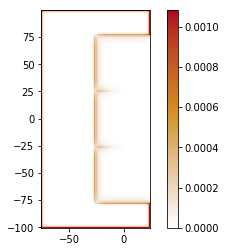

In [9]:
dens1 = np.abs(evecs[:, 0])**2

dens_tot = []
for i in range(0, 100*200, 1):
    dens_tot.append(dens1[4*i] + dens1[4*i+1] + dens1[4*i+2] + dens1[4*i+3])  # kwant store information site by site, here 4, 4, 4, ...

kwant.plotter.map(syst, dens_tot)
print()

# Scattering matrix

In [12]:
def scattering(phi):
    params = dict(A = 1, B = 0.5, m=-0.5, mu=0., delta_1=0., delta_2=0.75, delta_3=0.75, phi=phi, 
              cos=np.cos, sin=np.sin, f_rRe=f_rRe, f_rIm=f_rIm)  #sigma is no need to input
    smatrix = kwant.solvers.mumps.smatrix(syst, energy=0.001, params=params, out_leads=[1], in_leads=[0]) #out_leads=[1], in_leads=[0] if necessary
    s_temp = smatrix.data
    angle = -np.angle(s_temp[0][0], deg=False)
    return angle

In [ ]:
# numerical resutls
angle = []
phi_tot = [] 
nphi = 51
for i in range(0, nphi):
    dphi = np.pi*2.0 / nphi
    phi = i * dphi
    phi_tot.append(phi)
    phase_diff = scattering(phi) - scattering(0.0)
    if True:
        while phase_diff < 0:
            phase_diff += 2 * np.pi
        while phase_diff > 2 * np.pi:
            phase_diff -= 2 *np.pi
    angle.append(phase_diff)

In [ ]:
# analytical results: Formula A14 from the paper  
def alpha(phi):
    beta_pre = 4.04 # determined by W and coherence length
    mid_1 = np.cos(phi*0.5)
    beta = beta_pre * mid_1
    mid_2 = np.tanh(beta)
    temp = (mid_1+mid_2) / (1.0 + mid_1*mid_2)
    
    return np.arccos(temp) * np.sign(phi)

angle_ana = []
for i in range(0, nphi):
    dphi = np.pi*2.0 / nphi
    phi = i * dphi
    alpha_diff = 2.0*(alpha(phi) - alpha(0.0))
    angle_ana.append(alpha_diff)

In [ ]:
#plot phase difference as a function of phi    
plt.figure()
plt.plot(phi_tot, angle, '.')
plt.plot(phi_tot, angle_ana)
plt.xlabel("phi$")
plt.ylabel("angle")
plt.xlim(0.0, np.pi*2.0)
plt.ylim(0, np.pi*2.0)
plt.show()